In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.cm import get_cmap


In [2]:
file_path = 'data/Assignment 3 - timeseries_data.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data['MARKETDAY'] = pd.to_datetime(data['MARKETDAY'])

data.set_index('DATETIME', inplace=True)
data['WEEKDAY'] = data['MARKETDAY'].dt.day_name()

## Anomaly Detection

In [3]:
wepeak_weekday_anomaly = (data['PEAKTYPE'] == 'WEPEAK') & (data['MARKETDAY'].dt.dayofweek < 5)
wepeak_weekdays_anomaly_data = data[wepeak_weekday_anomaly]
wepeak_weekdays_anomaly_data.head()

,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR,WEEKDAY
DATETIME,,,,,,,,,,
2017-01-02 07:00:00,17.1900,10671.29,0.00,29169.570555,7,2017-01-02,WEPEAK,JANUARY,2017,Monday
2017-01-02 08:00:00,18.1650,10725.83,1.68,30267.473250,8,2017-01-02,WEPEAK,JANUARY,2017,Monday
2017-01-02 09:00:00,18.5150,10676.44,104.68,31166.344763,9,2017-01-02,WEPEAK,JANUARY,2017,Monday
2017-01-02 10:00:00,19.4600,9493.16,368.88,32084.609650,10,2017-01-02,WEPEAK,JANUARY,2017,Monday
2017-01-02 11:00:00,19.8075,9064.19,422.94,33016.191940,11,2017-01-02,WEPEAK,JANUARY,2017,Monday


In [4]:
offpeak_anomaly = (data['PEAKTYPE'] == 'OFFPEAK') & (data.index.hour >= 7) & (data.index.hour <= 22)
offpeak_anomaly_data = data[offpeak_anomaly]
offpeak_anomaly_data.head()


,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR,WEEKDAY
DATETIME,,,,,,,,,,


In [5]:
wdpeak_weekend_anomaly = (data['PEAKTYPE'] == 'WDPEAK') & (data['MARKETDAY'].dt.dayofweek >= 5)
wdpeak_weekend_anomaly_data = data[wdpeak_weekend_anomaly]
wdpeak_weekend_anomaly_data.head()

,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR,WEEKDAY
DATETIME,,,,,,,,,,


In [6]:
onpeak_anomaly = ((data['PEAKTYPE'] == 'WDPEAK') | (data['PEAKTYPE'] == 'WEPEAK')) & (data.index.hour < 7) & (data.index.hour > 22)
onpeak_anomaly_data = data[onpeak_anomaly]
onpeak_anomaly_data.head()

,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR,WEEKDAY
DATETIME,,,,,,,,,,


In [7]:
# fix the anomaly
data.loc[wepeak_weekday_anomaly, 'PEAKTYPE'] = 'WDPEAK'

## EDA

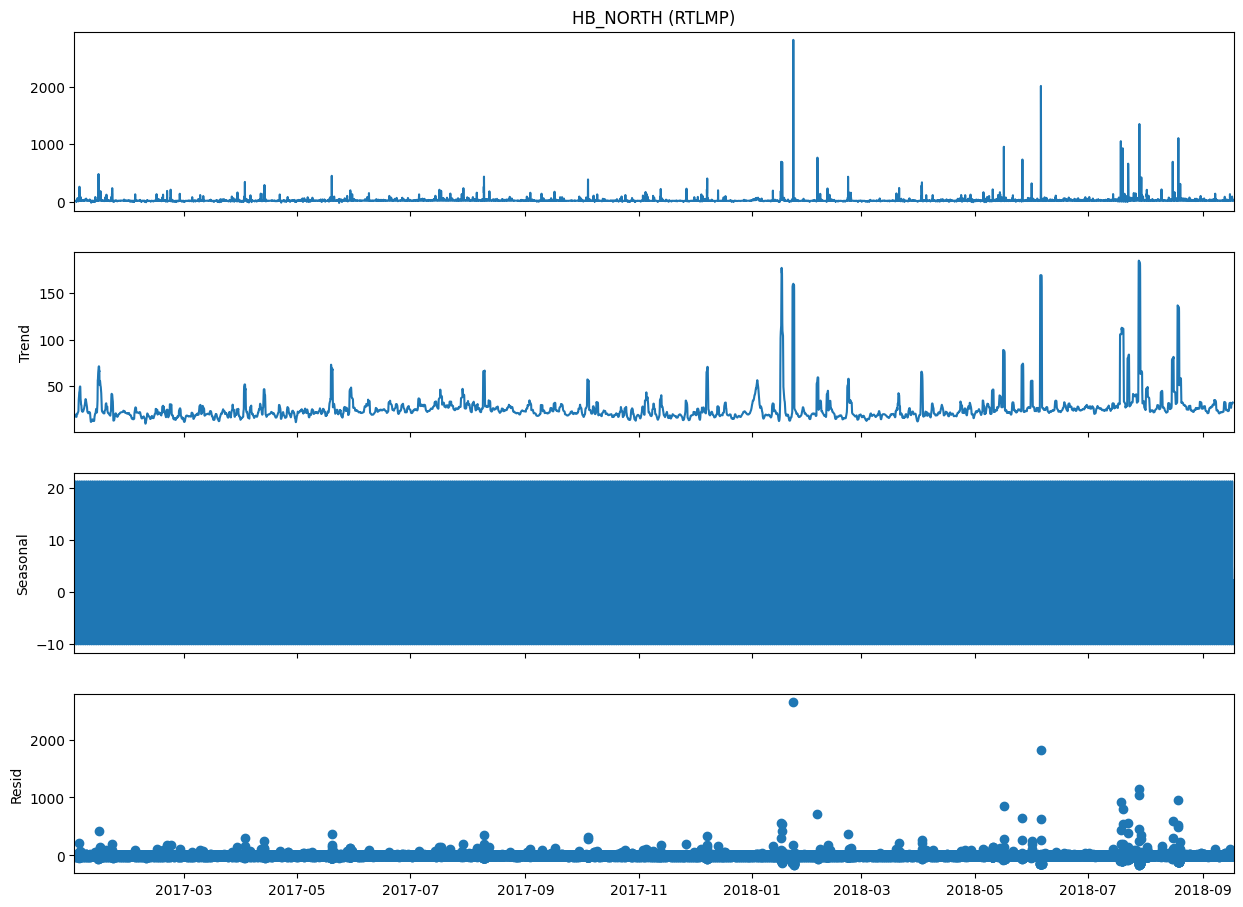

In [8]:
# Seasonal Decomposition on HB_NORTH (RTLMP) for all 3 peaktypes
decomposition = sm.tsa.seasonal_decompose(data['HB_NORTH (RTLMP)'].dropna(), model='additive', period=24)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

## Seasonal Decomposition by PEAKTYPE

In [9]:
# segment the data by PEAKTYPE
offpeak_data = data[data['PEAKTYPE'] == 'OFFPEAK'].copy()
wepeak_data = data[data['PEAKTYPE'] == 'WEPEAK'].copy()
wdpeak_data = data[data['PEAKTYPE'] == 'WDPEAK'].copy()

# perform seasonal decomposition for each PEAKTYPE
decomposition_offpeak = sm.tsa.seasonal_decompose(offpeak_data['HB_NORTH (RTLMP)'], model='additive', period=24)
decomposition_wepeak = sm.tsa.seasonal_decompose(wepeak_data['HB_NORTH (RTLMP)'], model='additive', period=24)
decomposition_wdpeak = sm.tsa.seasonal_decompose(wdpeak_data['HB_NORTH (RTLMP)'], model='additive', period=24)

# for visualization
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE', 
               'JULY', 'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER']

wdpeak_data['WEEKDAY'] = pd.Categorical(wdpeak_data['WEEKDAY'], categories=weekday_order, ordered=True)
wdpeak_data['MONTH'] = pd.Categorical(wdpeak_data['MONTH'], categories=month_order, ordered=True)

wepeak_data['WEEKDAY'] = pd.Categorical(wepeak_data['WEEKDAY'], categories=weekday_order, ordered=True)
wepeak_data['MONTH'] = pd.Categorical(wepeak_data['MONTH'], categories=month_order, ordered=True)

offpeak_data['WEEKDAY'] = pd.Categorical(offpeak_data['WEEKDAY'], categories=weekday_order, ordered=True)
offpeak_data['MONTH'] = pd.Categorical(offpeak_data['MONTH'], categories=month_order, ordered=True)

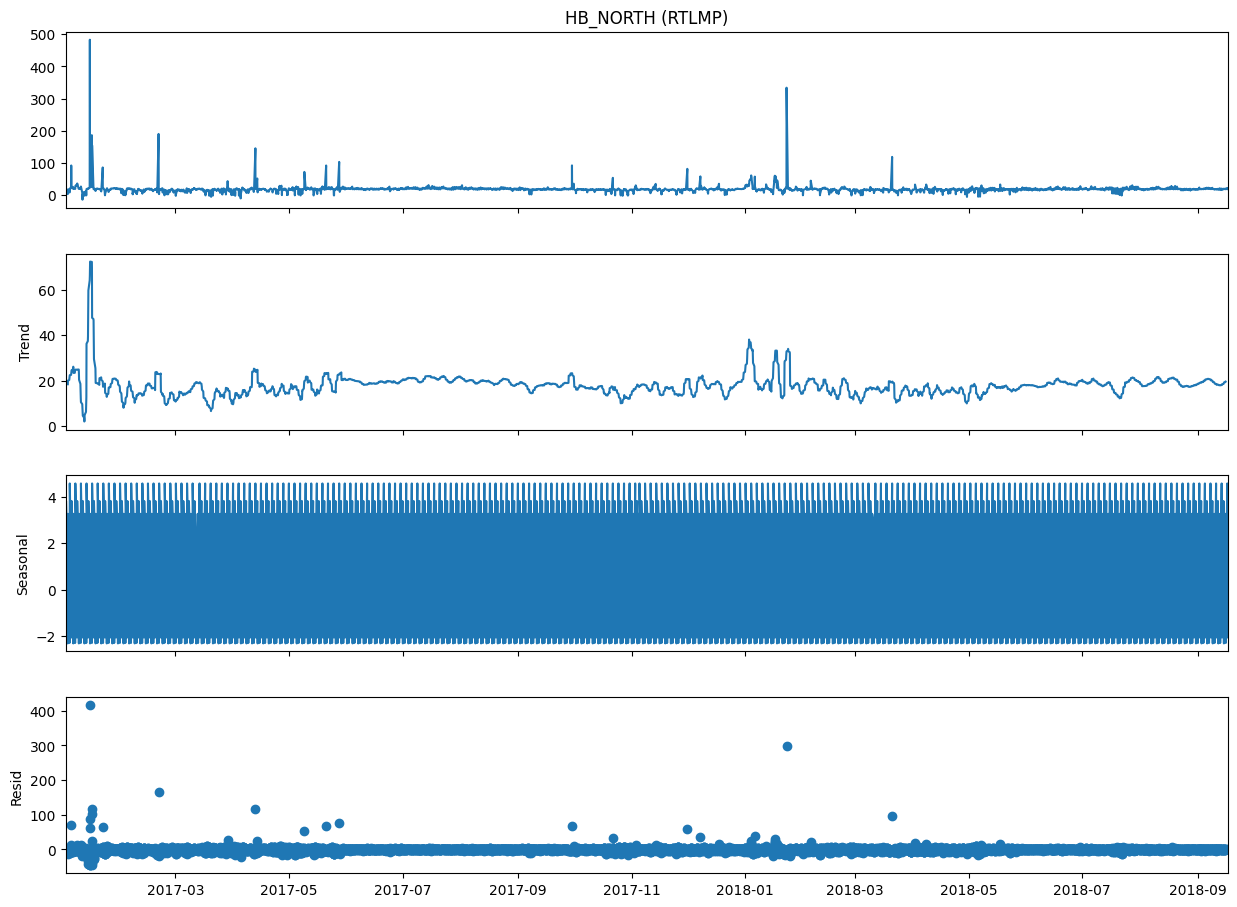

In [10]:
fig = decomposition_offpeak.plot()
fig.set_size_inches(14, 10)
plt.show()

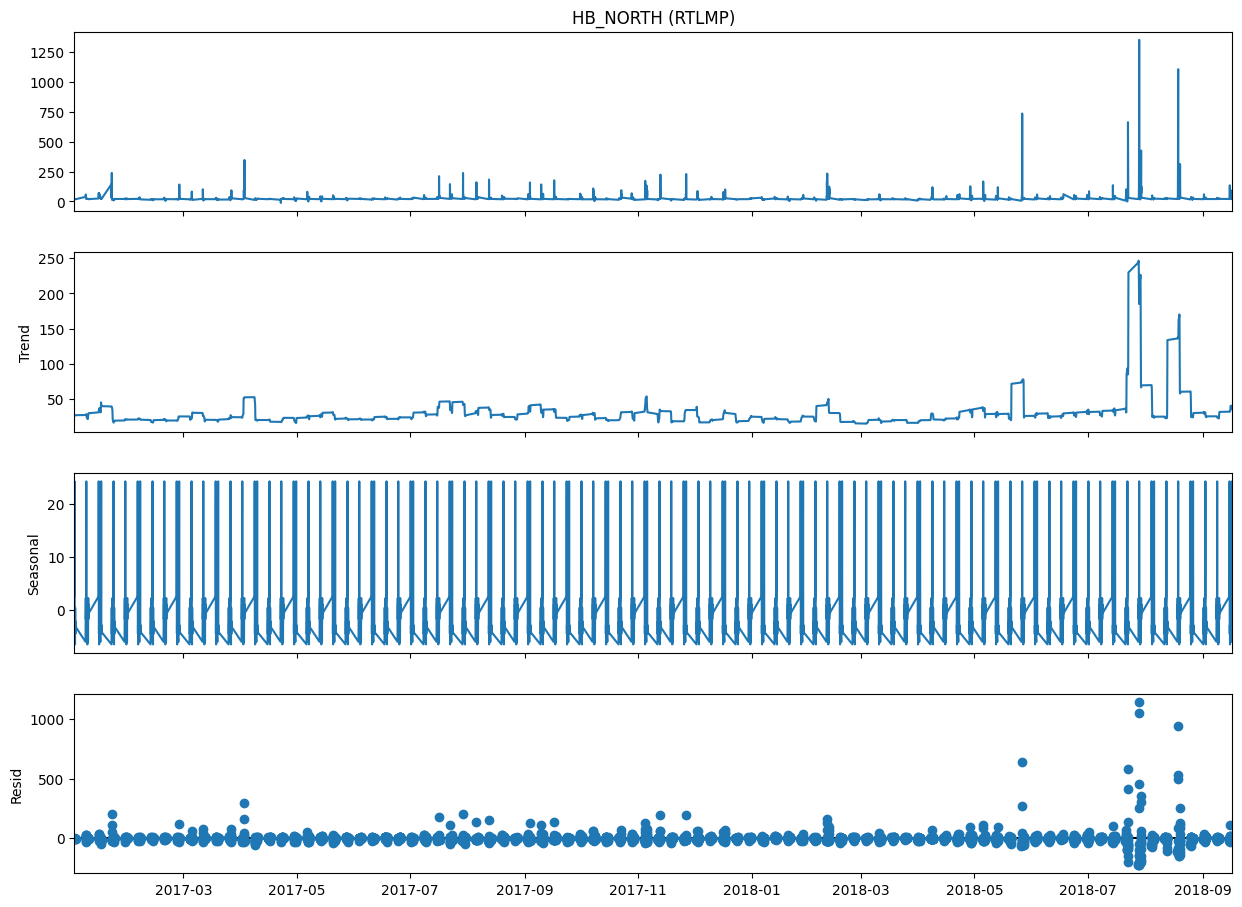

In [11]:
fig = decomposition_wepeak.plot()
fig.set_size_inches(14, 10)
plt.show()

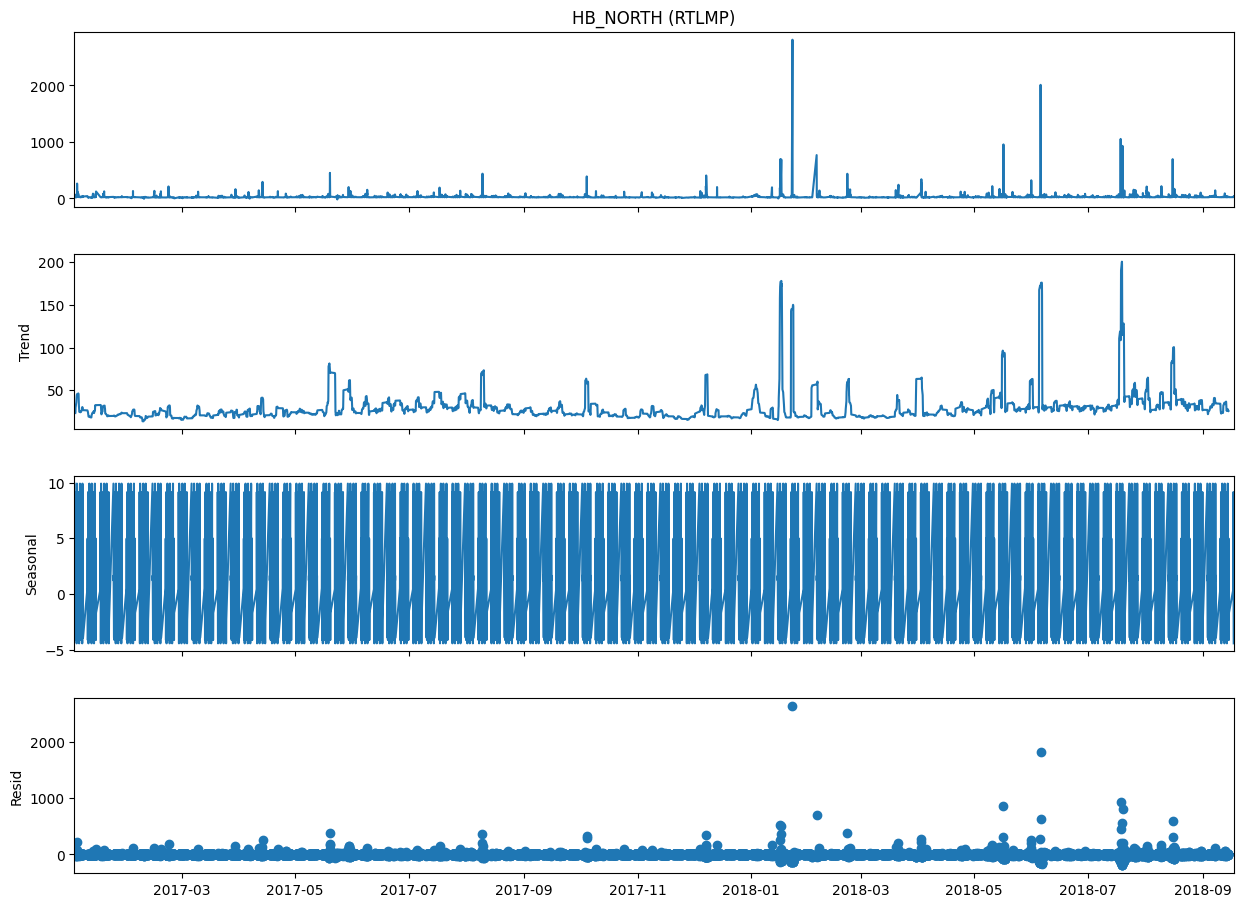

In [12]:
fig = decomposition_wdpeak.plot()
fig.set_size_inches(14, 10)
plt.show()

## Visualization on Hourly and Daily Basis

/var/folders/z3/fc8k4pzx65x1g3wjk_ckpfw80000gn/T/ipykernel_30030/3510241815.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_wk = get_cmap('tab20', len(weekday_order))
/var/folders/z3/fc8k4pzx65x1g3wjk_ckpfw80000gn/T/ipykernel_30030/3510241815.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_mo = get_cmap('tab20', len(month_order))


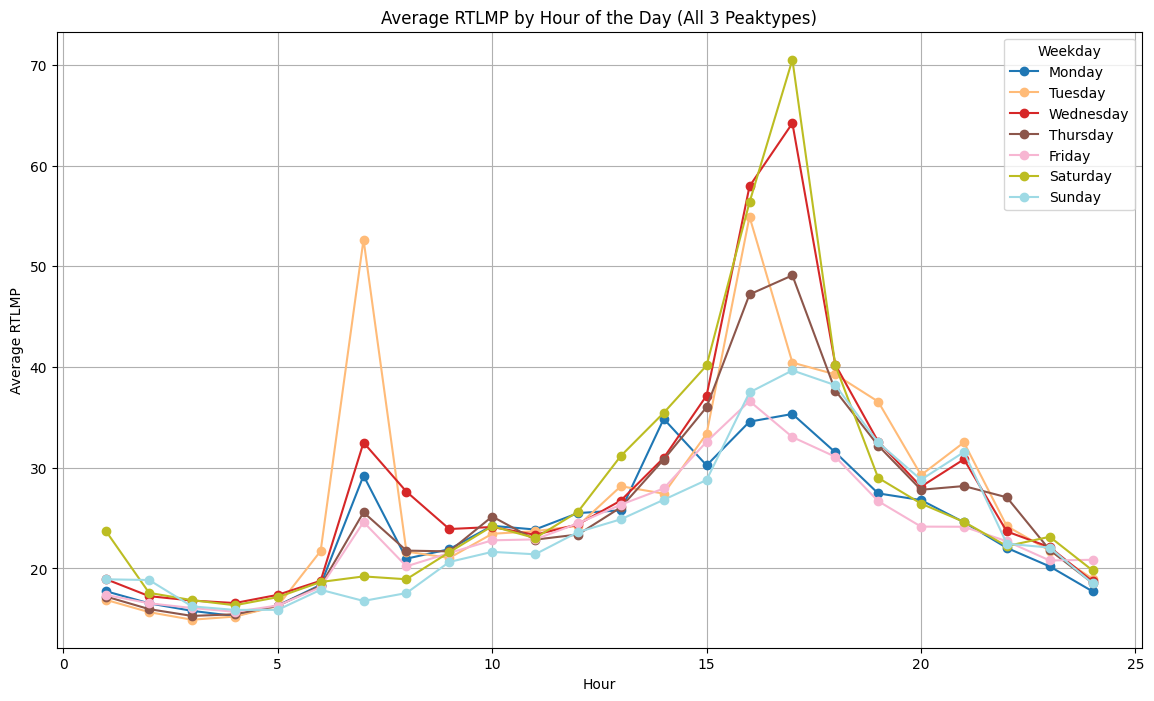

In [13]:
# calculate average HB_NORTH (RTLMP) by weekday and hour
avg_by_weekday_hours = data.groupby(['WEEKDAY', 'HOURENDING'])['HB_NORTH (RTLMP)'].mean().unstack()

cmap_wk = get_cmap('tab20', len(weekday_order))
cmap_mo = get_cmap('tab20', len(month_order))

plt.figure(figsize=(14, 8))
for i, wkday in enumerate(weekday_order):
    if wkday in avg_by_weekday_hours.index:
        plt.plot(avg_by_weekday_hours.columns, avg_by_weekday_hours.loc[wkday], label=f'{wkday}', color=cmap_wk(i), marker='o')

# set labels to Monday through Friday
plt.title('Average RTLMP by Hour of the Day (All 3 Peaktypes)')
plt.xlabel('Hour')
plt.ylabel('Average RTLMP')
plt.legend(title='Weekday', loc='upper right')
plt.grid(True)
plt.show()

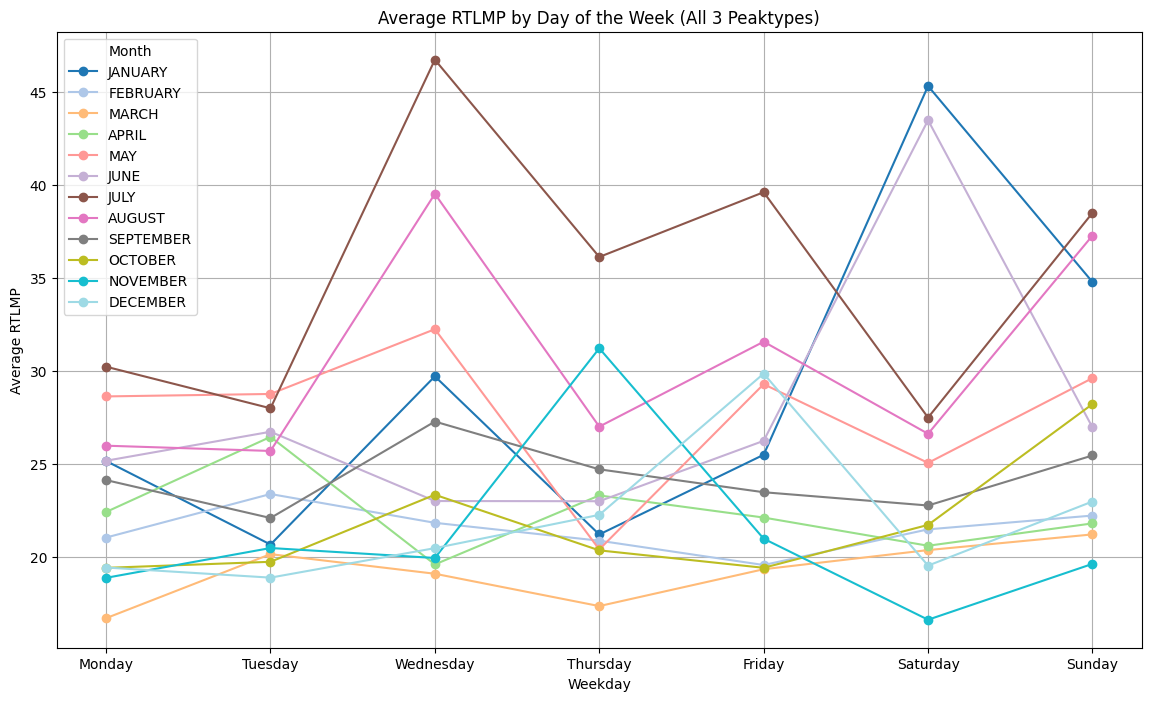

In [14]:
# calculate average HB_NORTH (RTLMP) by month and weekday
avg_by_month_weekday = data.groupby(['MONTH', 'WEEKDAY'])['HB_NORTH (RTLMP)'].mean().unstack()

plt.figure(figsize=(14, 8))

for i, month in enumerate(month_order):
    if month in avg_by_month_weekday.index:
        plt.plot(avg_by_month_weekday.columns, avg_by_month_weekday.loc[month], label=f'{month}', color=cmap_mo(i),marker='o')


plt.xticks(ticks=range(7), labels=weekday_order)
plt.title('Average RTLMP by Day of the Week (All 3 Peaktypes)')
plt.xlabel('Weekday')
plt.ylabel('Average RTLMP')
plt.legend(title='Month')
plt.grid(True)
plt.show()

### ONPEAK

/var/folders/z3/fc8k4pzx65x1g3wjk_ckpfw80000gn/T/ipykernel_30030/912105688.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_wdpeak_by_weekday_hours = wdpeak_data.groupby(['WEEKDAY', 'HOURENDING'])['HB_NORTH (RTLMP)'].mean().unstack()
/var/folders/z3/fc8k4pzx65x1g3wjk_ckpfw80000gn/T/ipykernel_30030/912105688.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_wk = get_cmap('tab20', len(weekday_order))
/var/folders/z3/fc8k4pzx65x1g3wjk_ckpfw80000gn/T/ipykernel_30030/912105688.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``m

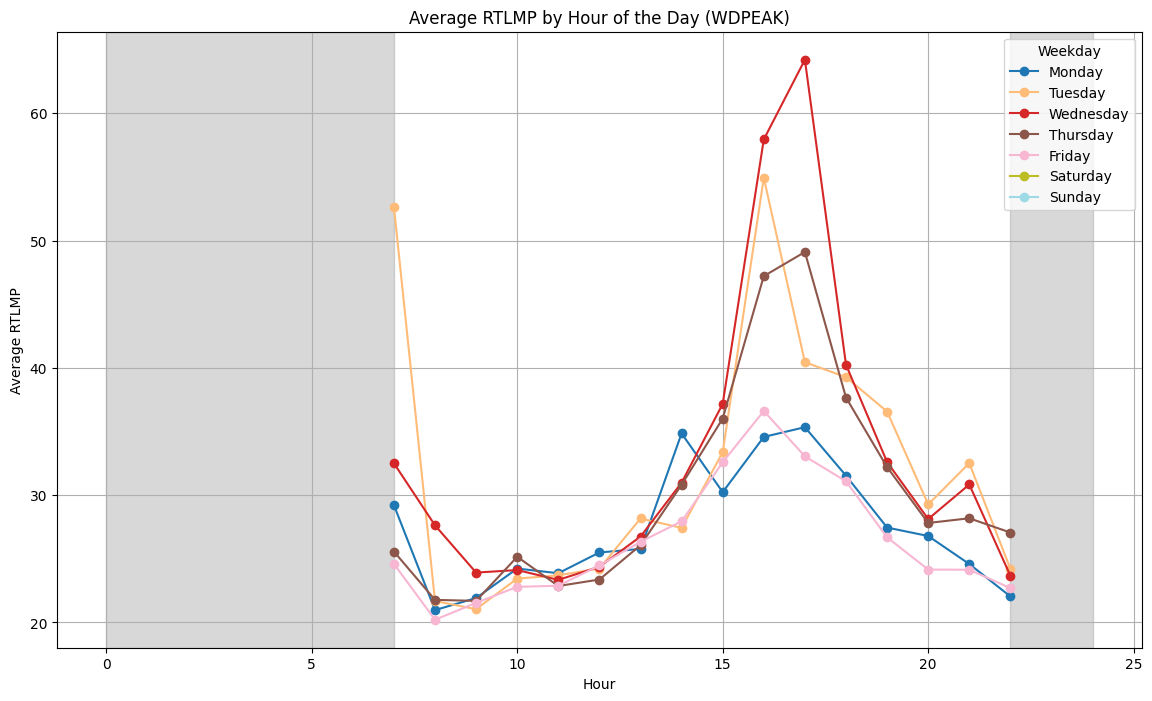

In [15]:
avg_wdpeak_by_weekday_hours = wdpeak_data.groupby(['WEEKDAY', 'HOURENDING'])['HB_NORTH (RTLMP)'].mean().unstack()

cmap_wk = get_cmap('tab20', len(weekday_order))
cmap_mo = get_cmap('tab20', len(month_order))

plt.figure(figsize=(14, 8))
for i, wkday in enumerate(weekday_order):
    if wkday in avg_wdpeak_by_weekday_hours.index:
        plt.plot(avg_wdpeak_by_weekday_hours.columns, avg_wdpeak_by_weekday_hours.loc[wkday], label=f'{wkday}', color=cmap_wk(i), marker='o')


plt.axvspan(0, 7, color='grey', alpha=0.3)
plt.axvspan(22, 24, color='grey', alpha=0.3)
plt.title('Average RTLMP by Hour of the Day (WDPEAK)')
plt.xlabel('Hour')
plt.ylabel('Average RTLMP')
plt.legend(title='Weekday', loc='upper right')
plt.grid(True)
plt.show()

/var/folders/z3/fc8k4pzx65x1g3wjk_ckpfw80000gn/T/ipykernel_30030/2893932027.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_wdpeak_by_month_weekday = wdpeak_data.groupby(['MONTH', 'WEEKDAY'])['HB_NORTH (RTLMP)'].mean().unstack()


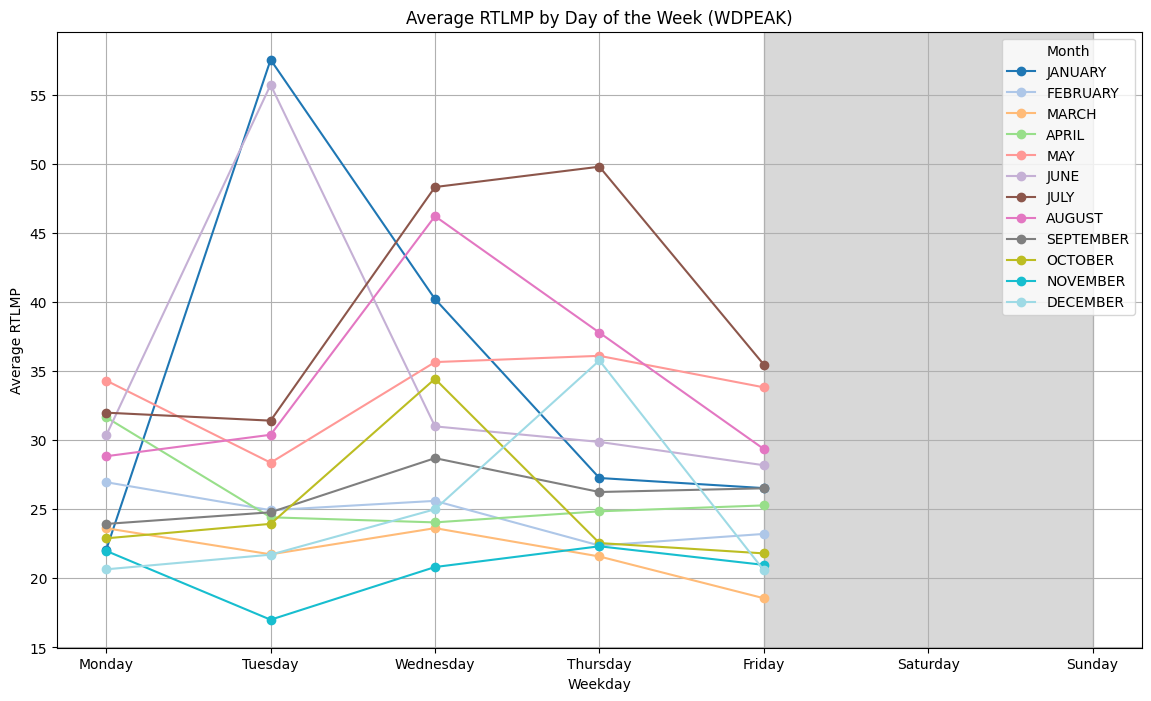

In [16]:
avg_wdpeak_by_month_weekday = wdpeak_data.groupby(['MONTH', 'WEEKDAY'])['HB_NORTH (RTLMP)'].mean().unstack()

plt.figure(figsize=(14, 8))

for i, month in enumerate(month_order):
    if month in avg_wdpeak_by_month_weekday.index:
        plt.plot(avg_wdpeak_by_month_weekday.columns, avg_wdpeak_by_month_weekday.loc[month], label=f'{month}', color=cmap_mo(i),marker='o')

plt.axvspan(4, 6, color='grey', alpha=0.3)
plt.xticks(ticks=range(7), labels=weekday_order)
plt.title('Average RTLMP by Day of the Week (WDPEAK)')
plt.xlabel('Weekday')
plt.ylabel('Average RTLMP')
plt.legend(title='Month')
plt.grid(True)
plt.show()

### WEPEAK

/var/folders/z3/fc8k4pzx65x1g3wjk_ckpfw80000gn/T/ipykernel_30030/837484393.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_wepeak_by_weekday_hours = wepeak_data.groupby(['WEEKDAY', 'HOURENDING'])['HB_NORTH (RTLMP)'].mean().unstack()


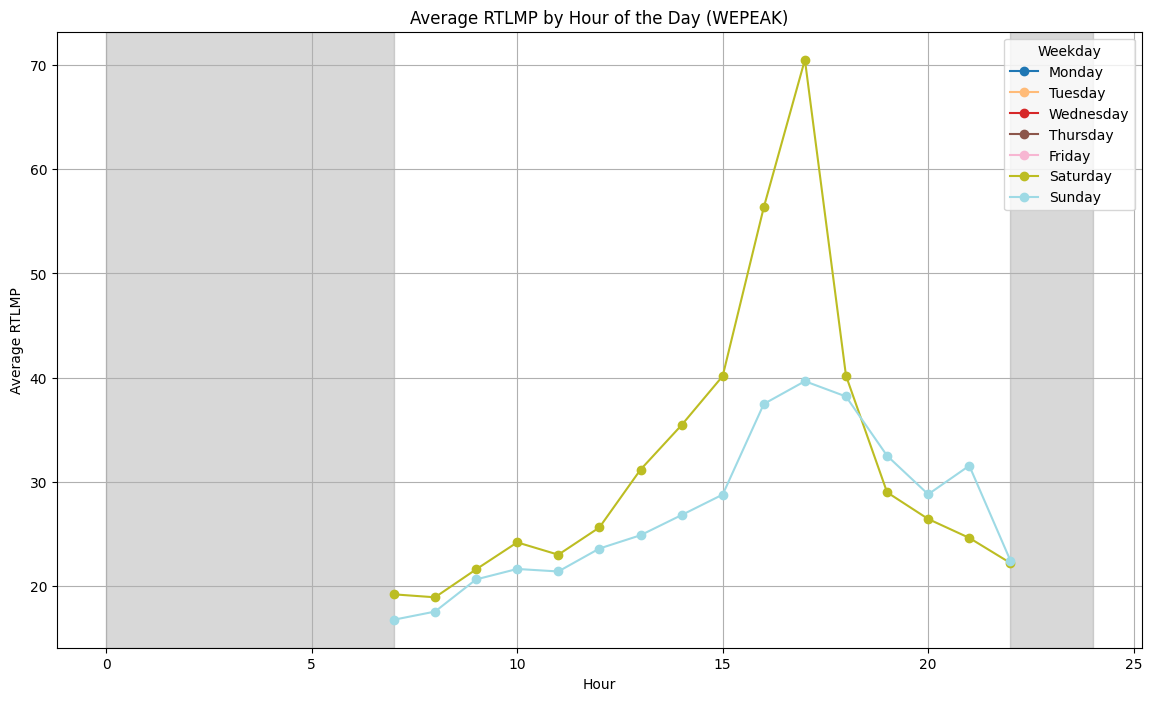

In [17]:
avg_wepeak_by_weekday_hours = wepeak_data.groupby(['WEEKDAY', 'HOURENDING'])['HB_NORTH (RTLMP)'].mean().unstack()
plt.figure(figsize=(14, 8))


for i, wkday in enumerate(weekday_order):
    if wkday in avg_wepeak_by_weekday_hours.index:
        plt.plot(avg_wepeak_by_weekday_hours.columns, avg_wepeak_by_weekday_hours.loc[wkday], label=f'{wkday}', color=cmap_wk(i), marker='o')


plt.axvspan(0, 7, color='grey', alpha=0.3)
plt.axvspan(22, 24, color='grey', alpha=0.3)
plt.title('Average RTLMP by Hour of the Day (WEPEAK)')
plt.xlabel('Hour')
plt.ylabel('Average RTLMP')
plt.legend(title='Weekday', loc='upper right')
plt.grid(True)
plt.show()

/var/folders/z3/fc8k4pzx65x1g3wjk_ckpfw80000gn/T/ipykernel_30030/920180905.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_wepeak_by_month_weekday = wepeak_data.groupby(['MONTH', 'WEEKDAY'])['HB_NORTH (RTLMP)'].mean().unstack()


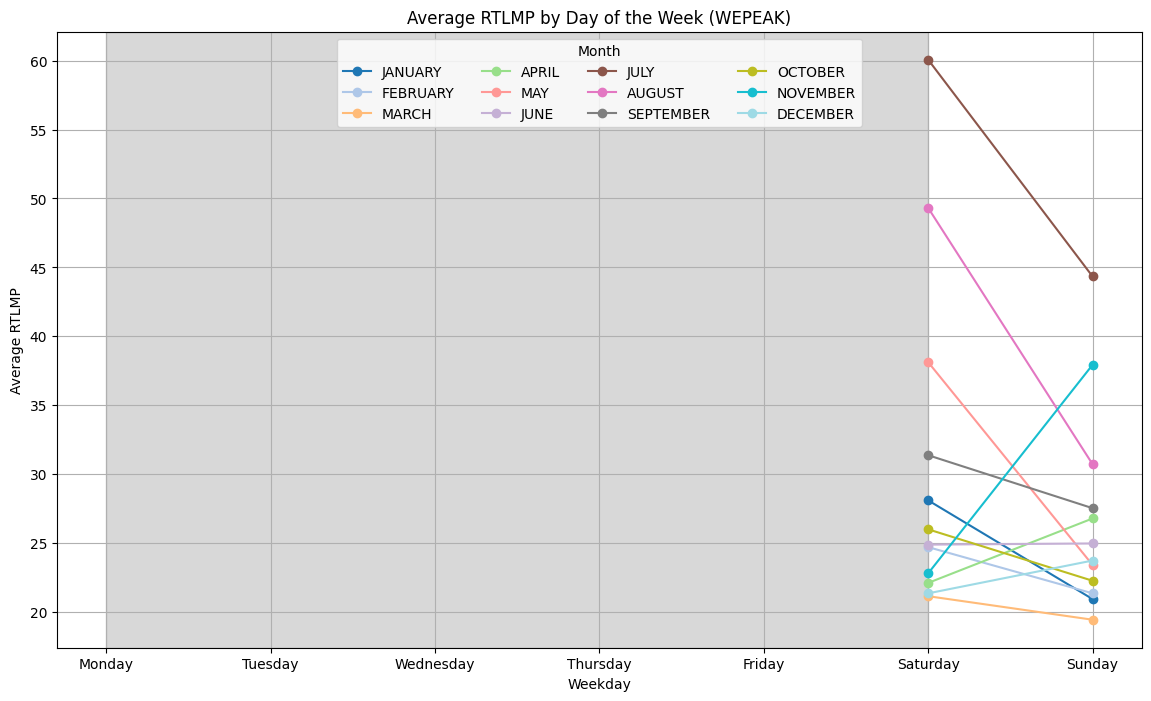

In [18]:
avg_wepeak_by_month_weekday = wepeak_data.groupby(['MONTH', 'WEEKDAY'])['HB_NORTH (RTLMP)'].mean().unstack()
plt.figure(figsize=(14, 8))


for i, month in enumerate(month_order):
    if month in avg_wepeak_by_month_weekday.index:
        plt.plot(avg_wepeak_by_month_weekday.columns, avg_wepeak_by_month_weekday.loc[month], label=f'{month}', color=cmap_mo(i), marker='o')

plt.xticks(ticks=range(7), labels=weekday_order)
plt.axvspan(0, 5, color='grey', alpha=0.3)
plt.title('Average RTLMP by Day of the Week (WEPEAK)')
plt.xlabel('Weekday')
plt.ylabel('Average RTLMP')
plt.legend(title='Month', loc='upper center', bbox_to_anchor=(0.5, 1), ncol=4)
plt.grid(True)
plt.show()

### OFFPEAK

/var/folders/z3/fc8k4pzx65x1g3wjk_ckpfw80000gn/T/ipykernel_30030/3218164919.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_offpeak_by_weekday_hours = offpeak_data.groupby(['WEEKDAY', 'HOURENDING'])['HB_NORTH (RTLMP)'].mean().unstack()


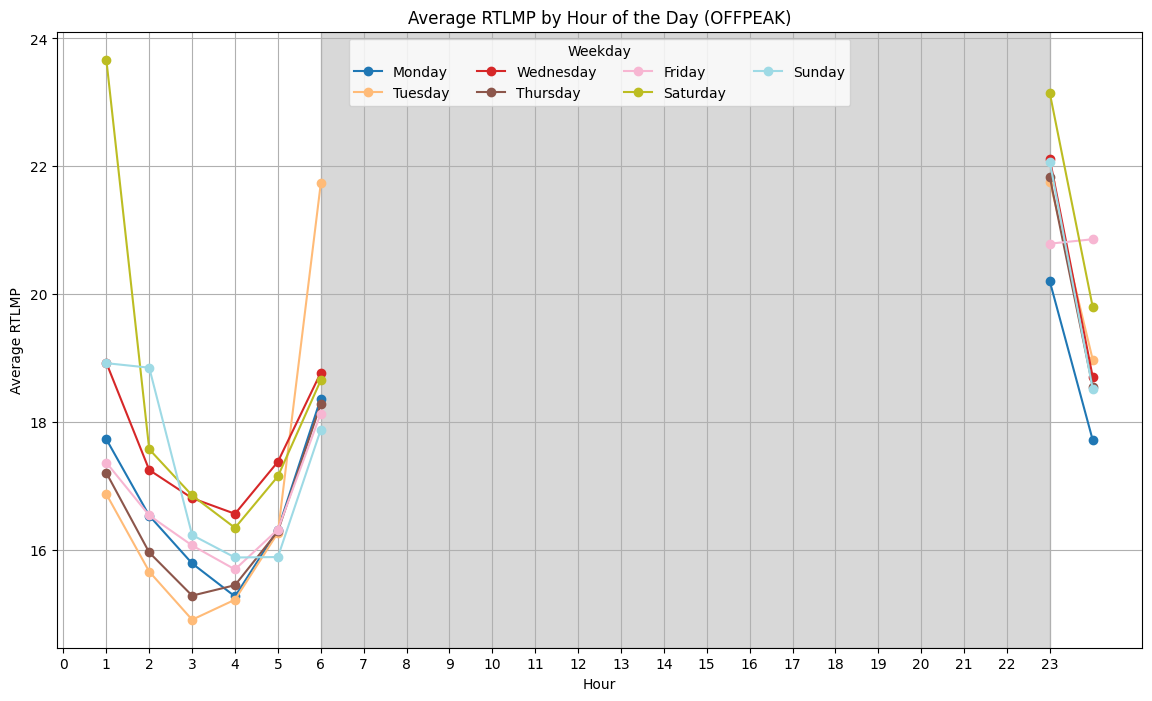

In [19]:
avg_offpeak_by_weekday_hours = offpeak_data.groupby(['WEEKDAY', 'HOURENDING'])['HB_NORTH (RTLMP)'].mean().unstack()
plt.figure(figsize=(14, 8))

for i, wkday in enumerate(weekday_order):
    if wkday in avg_offpeak_by_weekday_hours.index:
        plt1 = avg_offpeak_by_weekday_hours.loc[wkday]
        data_before_gap = plt1[plt1.index < 7]
        plt.plot(data_before_gap.index, data_before_gap.values, label=f'{wkday}', color=cmap_wk(i), marker='o')
        data_after_gap = plt1[plt1.index > 22]
        plt.plot(data_after_gap.index, data_after_gap.values, color=cmap_wk(i), marker='o')

plt.axvspan(6, 23, color='grey', alpha=0.3)
plt.xticks(ticks=range(24), labels=range(24))

plt.title('Average RTLMP by Hour of the Day (OFFPEAK)')
plt.xlabel('Hour')
plt.ylabel('Average RTLMP')
plt.legend(title='Weekday', loc='upper center', bbox_to_anchor=(0.5, 1), ncol=4)
plt.grid(True)
plt.show()

/var/folders/z3/fc8k4pzx65x1g3wjk_ckpfw80000gn/T/ipykernel_30030/3053759618.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_offpeak_by_month_weekday = offpeak_data.groupby(['MONTH', 'WEEKDAY'])['HB_NORTH (RTLMP)'].mean().unstack()


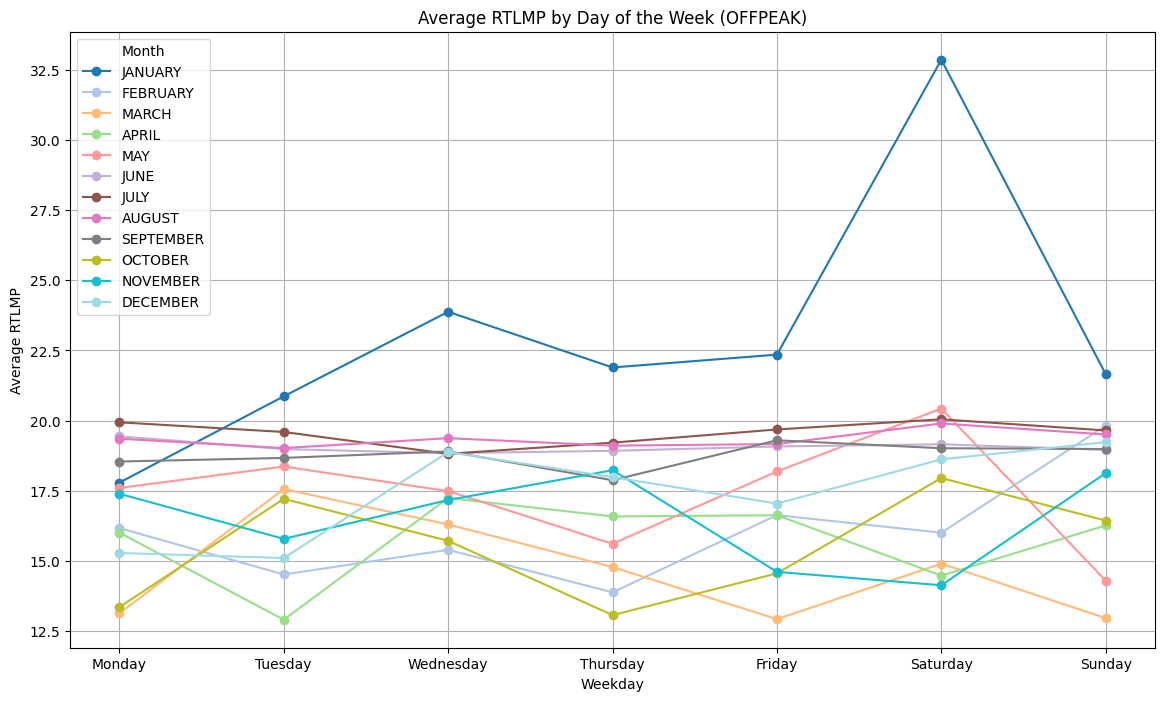

In [20]:
avg_offpeak_by_month_weekday = offpeak_data.groupby(['MONTH', 'WEEKDAY'])['HB_NORTH (RTLMP)'].mean().unstack()
plt.figure(figsize=(14, 8))

for i, month in enumerate(month_order):
    if month in avg_offpeak_by_month_weekday.index:
        plt.plot(avg_offpeak_by_month_weekday.columns, avg_offpeak_by_month_weekday.loc[month], label=f'{month}', color=cmap_mo(i), marker='o')


plt.xticks(ticks=range(7), labels=weekday_order)
plt.title('Average RTLMP by Day of the Week (OFFPEAK)')
plt.xlabel('Weekday')
plt.ylabel('Average RTLMP')
plt.legend(title='Month')
plt.grid(True)
plt.show()

## Seasonal Decomposition of Independent Variables

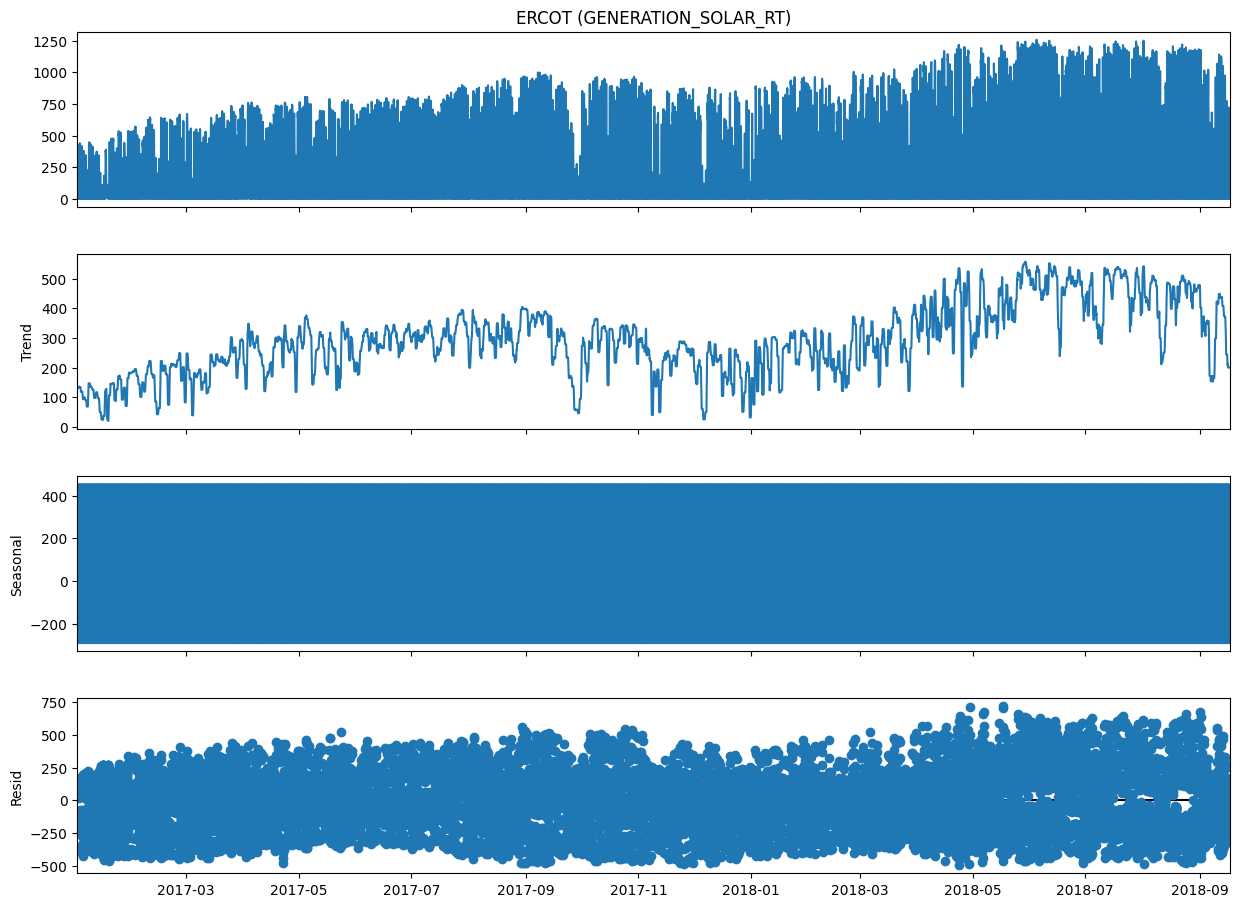

In [21]:
# Seasonal Decomposition for ERCOT (GENERATION_SOLAR_RT)
decomposition = sm.tsa.seasonal_decompose(data['ERCOT (GENERATION_SOLAR_RT)'].dropna(), model='additive', period=24)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

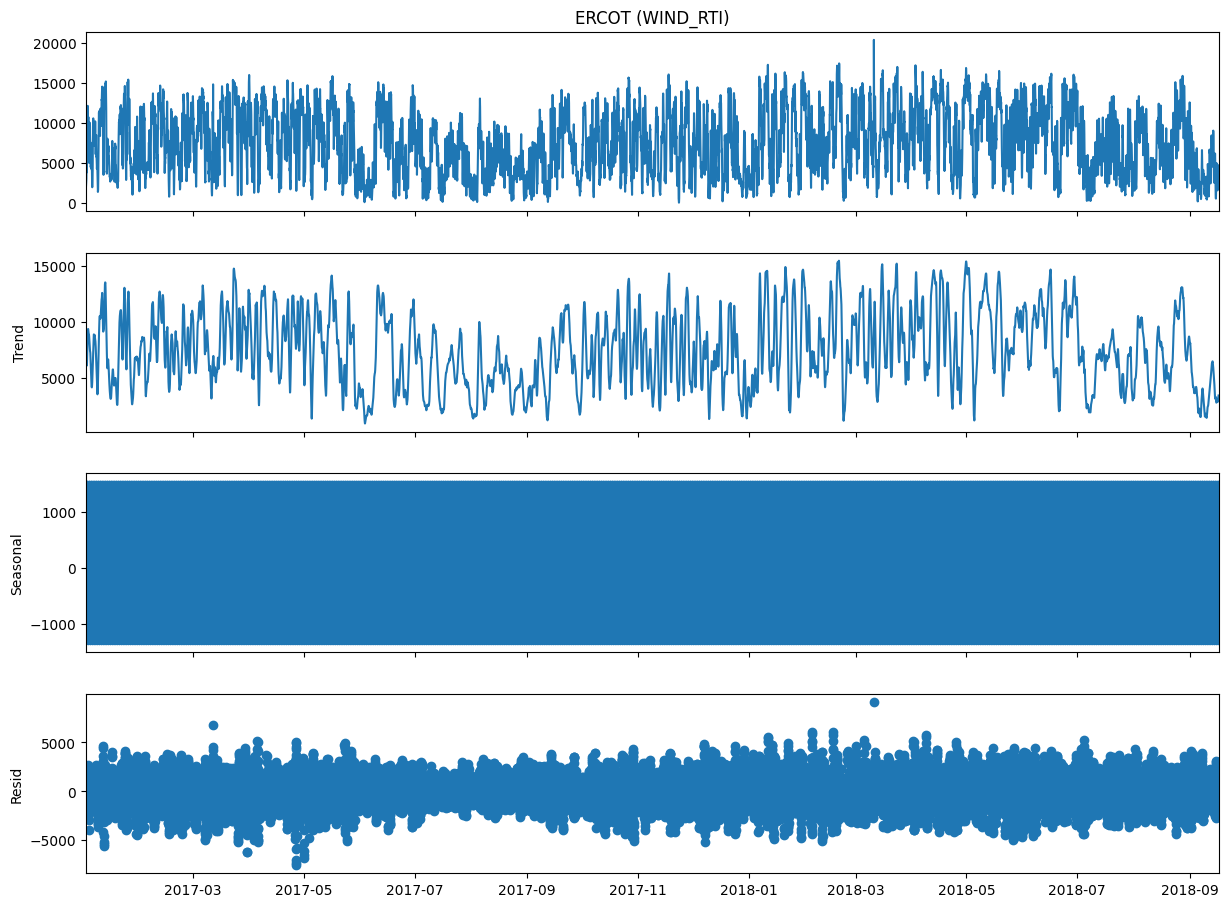

In [22]:
# Seasonal Decomposition for ERCOT (WIND_RTI)
decomposition = sm.tsa.seasonal_decompose(data['ERCOT (WIND_RTI)'].dropna(), model='additive', period=24)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

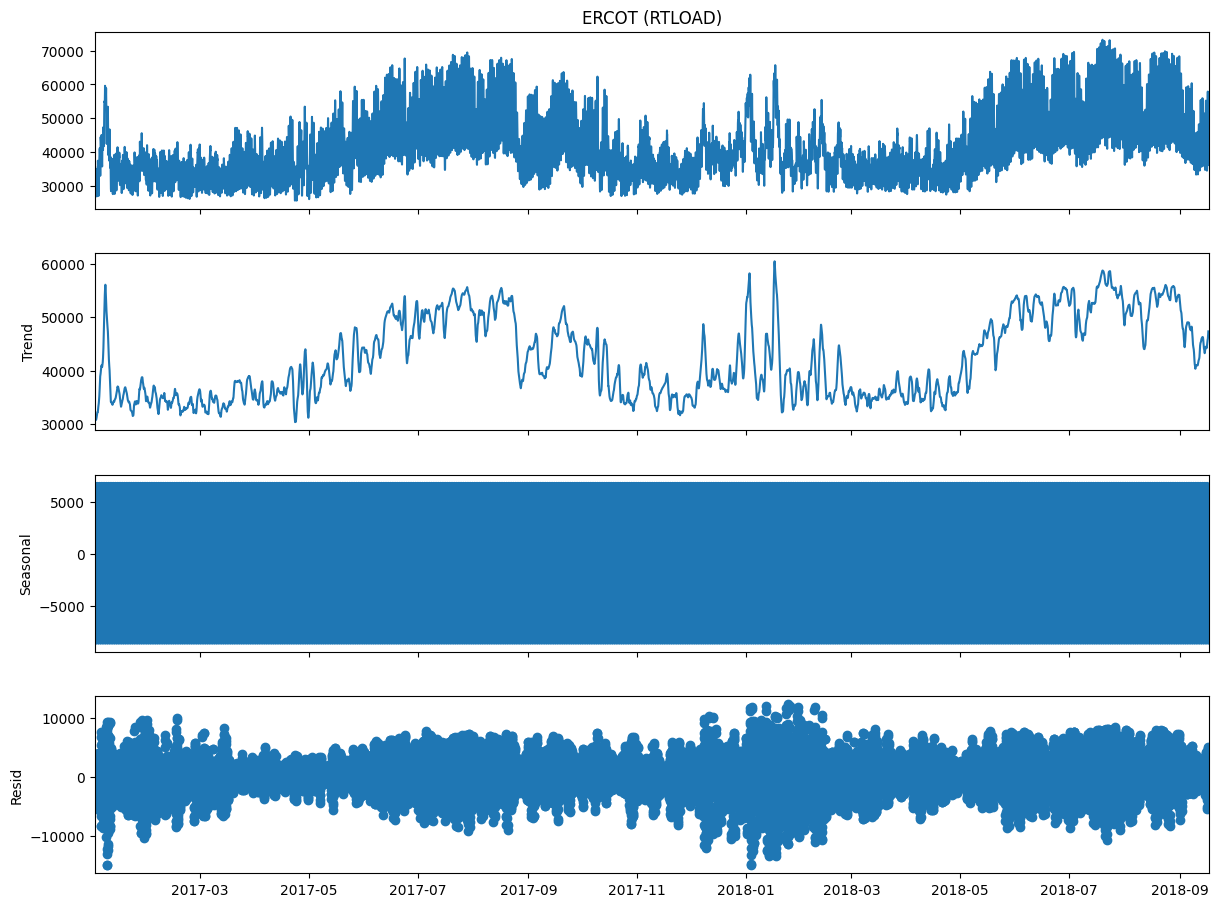

In [23]:
# Seasonal Decomposition for ERCOT (RTLOAD)
decomposition = sm.tsa.seasonal_decompose(data['ERCOT (RTLOAD)'].dropna(), model='additive', period=24)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

## Forecasting

In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import matplotlib.pyplot as plt

In [25]:

# load the data
file_path = 'data/Assignment 3 - timeseries_data.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data['MARKETDAY'] = pd.to_datetime(data['MARKETDAY'])

data.set_index('DATETIME', inplace=True)
data['WEEKDAY'] = data['MARKETDAY'].dt.day_name()

# anomaly detection
wepeak_weekday_anomaly = (data['PEAKTYPE'] == 'WEPEAK') & (data['MARKETDAY'].dt.dayofweek < 5)
wepeak_weekdays_anomaly_data = data[wepeak_weekday_anomaly]
offpeak_anomaly = (data['PEAKTYPE'] == 'OFFPEAK') & (data.index.hour >= 7) & (data.index.hour <= 22)
offpeak_anomaly_data = data[offpeak_anomaly]
wdpeak_weekend_anomaly = (data['PEAKTYPE'] == 'WDPEAK') & (data['MARKETDAY'].dt.dayofweek >= 5)
wdpeak_weekend_anomaly_data = data[wdpeak_weekend_anomaly]
onpeak_anomaly = ((data['PEAKTYPE'] == 'WDPEAK') | (data['PEAKTYPE'] == 'WEPEAK')) & (data.index.hour < 7) & (data.index.hour > 22)
onpeak_anomaly_data = data[onpeak_anomaly]

# fix the anomaly
data.loc[wepeak_weekday_anomaly, 'PEAKTYPE'] = 'WDPEAK'


# shift the columns 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)' by one time step
data['ERCOT (WIND_RTI)_lag'] = data['ERCOT (WIND_RTI)'].shift(1)
data['ERCOT (GENERATION_SOLAR_RT)_lag'] = data['ERCOT (GENERATION_SOLAR_RT)'].shift(1)
data['ERCOT (RTLOAD)_lag'] = data['ERCOT (RTLOAD)'].shift(1)

# add rolling statistics
data['WIND_RTI_roll_mean'] = data['ERCOT (WIND_RTI)'].rolling(window=24).mean()
data['GENERATION_SOLAR_RT_roll_mean'] = data['ERCOT (GENERATION_SOLAR_RT)'].rolling(window=24).mean()
data['RTLOAD_roll_mean'] = data['ERCOT (RTLOAD)'].rolling(window=24).mean()
data['WIND_RTI_roll_std'] = data['ERCOT (WIND_RTI)'].rolling(window=24).std()
data['GENERATION_SOLAR_RT_roll_std'] = data['ERCOT (GENERATION_SOLAR_RT)'].rolling(window=24).std()
data['RTLOAD_roll_std'] = data['ERCOT (RTLOAD)'].rolling(window=24).std()

data.dropna(inplace=True)
data.ffill(inplace=True)

# one-hot encodding
data = pd.get_dummies(data, columns=['PEAKTYPE', 'MONTH', 'WEEKDAY', 'YEAR', 'HOURENDING'], drop_first=True)
data = data.drop(['MARKETDAY'], axis=1)


# define features and target variable
features = [col for col in data.columns if col not in ['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']]
X = data[features]
y = data['HB_NORTH (RTLMP)']

# split the data into training, val, test sets
train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

val_size = int(len(X_train) * 0.2)
X_train, X_val = X_train[:-val_size], X_train[-val_size:]
y_train, y_val = y_train[:-val_size], y_train[-val_size:]

# scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# create time-series sequences for LSTM model
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24

X_train_scaled, y_train_scaled = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_val_scaled, y_val_scaled = create_sequences(X_val_scaled, y_val_scaled, time_steps)
X_test_scaled, y_test_scaled = create_sequences(X_test_scaled, y_test_scaled, time_steps)

print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")


X_train shape: (9520, 24, 52)
X_test shape: (2959, 24, 52)


In [26]:

# define the LSTM model
model = Sequential()
model.add(LSTM(200, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mean_absolute_error')

# train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), shuffle=False)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/50


2024-05-24 01:12:53.399087: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x24x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x24x1x200xi1>'
loc("mps_select"("(mpsFileLoc): 

  1/298 [..............................] - ETA: 20:23 - loss: 0.0282

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x24x1x200xi1>'


296/298 [============================>.] - ETA: 0s - loss: 0.0146

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<16x24x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<16x24x1x200xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerform

298/298 [==============================] - 15s 37ms/step - loss: 0.0146 - val_loss: 0.0027
Epoch 2/50
298/298 [==============================] - 10s 32ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 3/50
298/298 [==============================] - 10s 33ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 4/50
298/298 [==============================] - 10s 34ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 5/50
298/298 [==============================] - 10s 33ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 6/50
298/298 [==============================] - 10s 32ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 7/50
298/298 [==============================] - 10s 33ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 8/50
298/298 [==============================] - 10s 33ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 9/50
298/298 [==============================] - 10s 33ms/step - loss: 0.0024 - val_loss: 0.0037
Epoch 10/50
298/298 [==============================] - 10s 32ms/step - loss: 0.0024 - val_los

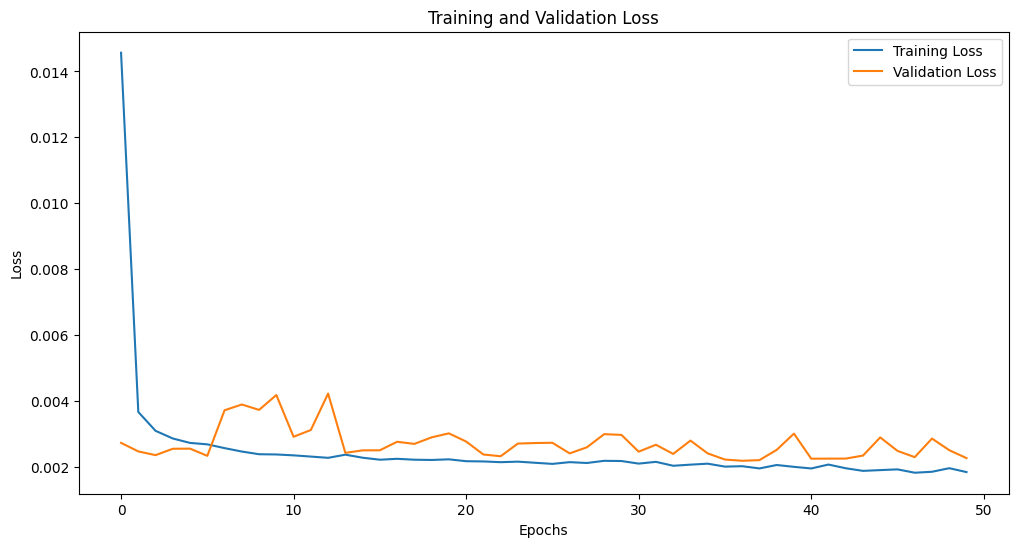

In [27]:
# plot the training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

298/298 [==============================] - 3s 11ms/step
Training RMSE: 35.58079131481683
Training MAPE: 0.7291871170253039


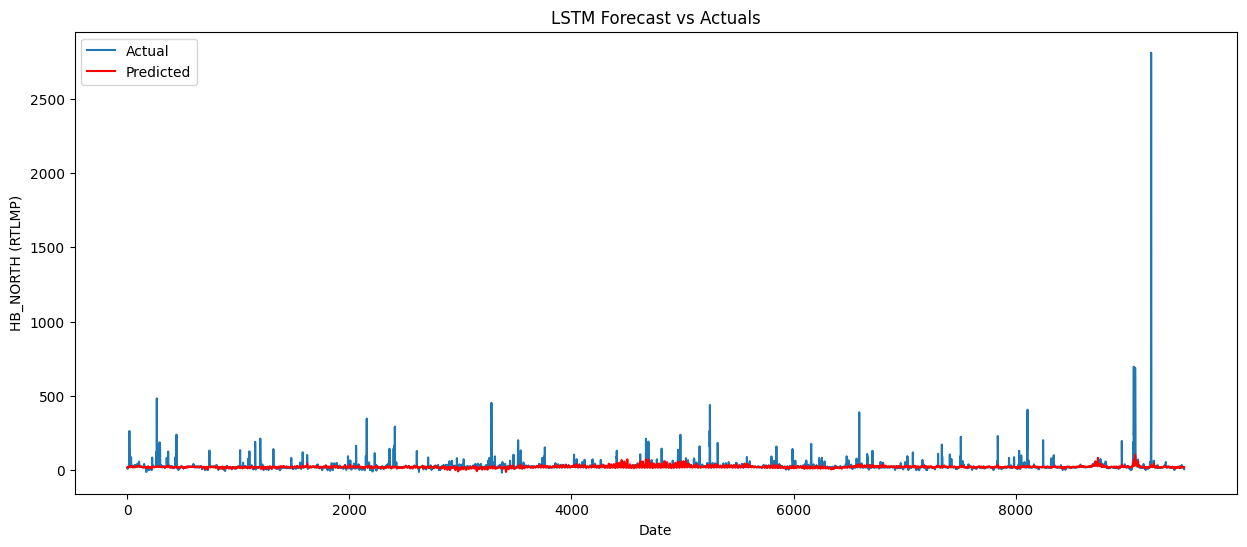

In [31]:
# check the model performance on the training and validation set
y_train_pred_scaled = model.predict(X_train_scaled)
y_train_pred = scaler_y.inverse_transform(np.array(y_train_pred_scaled).reshape(-1, 1))
y_train_actual = scaler_y.inverse_transform(y_train_scaled)

mse_train = mean_squared_error(y_train_actual, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train_actual, y_train_pred)
print(f"Training RMSE: {np.sqrt(mse_train)}")
print(f"Training MAPE: {mape_train}")

# plot the results
plt.figure(figsize=(15, 6))
plt.plot(y_train_actual, label='Actual')
plt.plot(y_train_pred, label='Predicted', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('HB_NORTH (RTLMP)')
plt.title('LSTM Forecast vs Actuals')
plt.show()

1/1 [==============================] - 0s 21ms/step
LSTM RMSE: 73.00028868566231
Testing MAPE: 0.3581350470719697


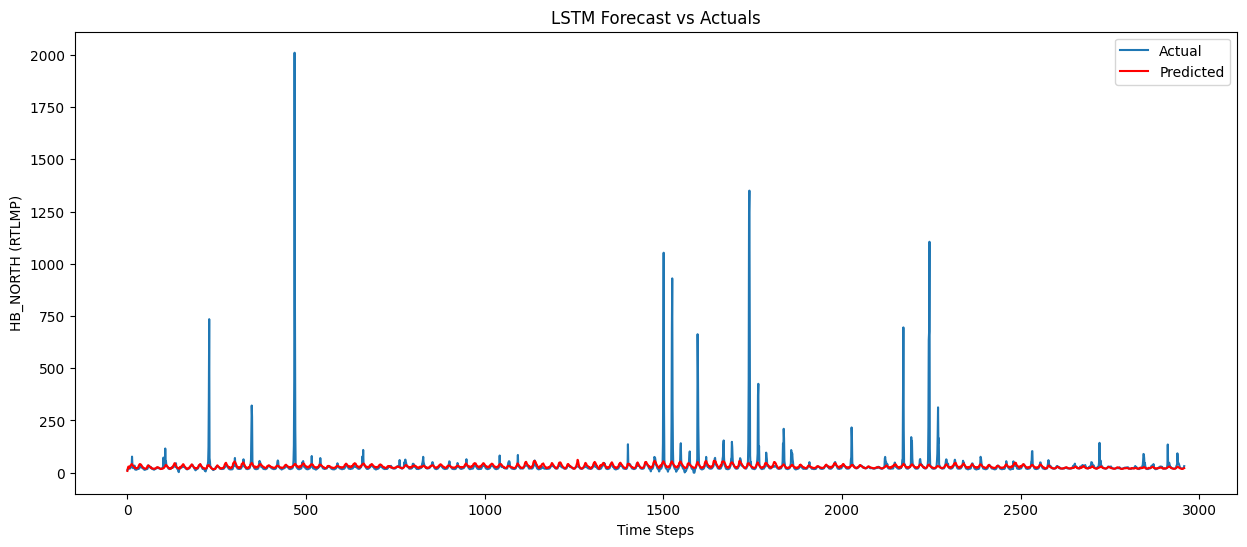

In [32]:
# apply the model to predict on the test set
y_pred_scaled = []
input_seq = X_test_scaled[:1] 

# predict step by step and update the target values
for i in range(len(X_test_scaled)):
    pred = model.predict(input_seq)
    y_pred_scaled.append(pred[0, 0])
    
    # update the input sequence for the next iteration
    if i + 1 < len(X_test_scaled):
        input_seq = np.roll(input_seq, -1, axis=1)
        # set up the predicted value
        input_seq[0, -1, :] = X_test_scaled[i + 1, -1, :]
        input_seq[0, -1, 0] = pred

y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f'LSTM RMSE: {rmse}')
test_mape = mean_absolute_percentage_error(y_test_actual, y_pred)
print(f'Testing MAPE: {test_mape}')

plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred, label='Predicted', color='red')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('HB_NORTH (RTLMP)')
plt.title('LSTM Forecast vs Actuals')
plt.show()


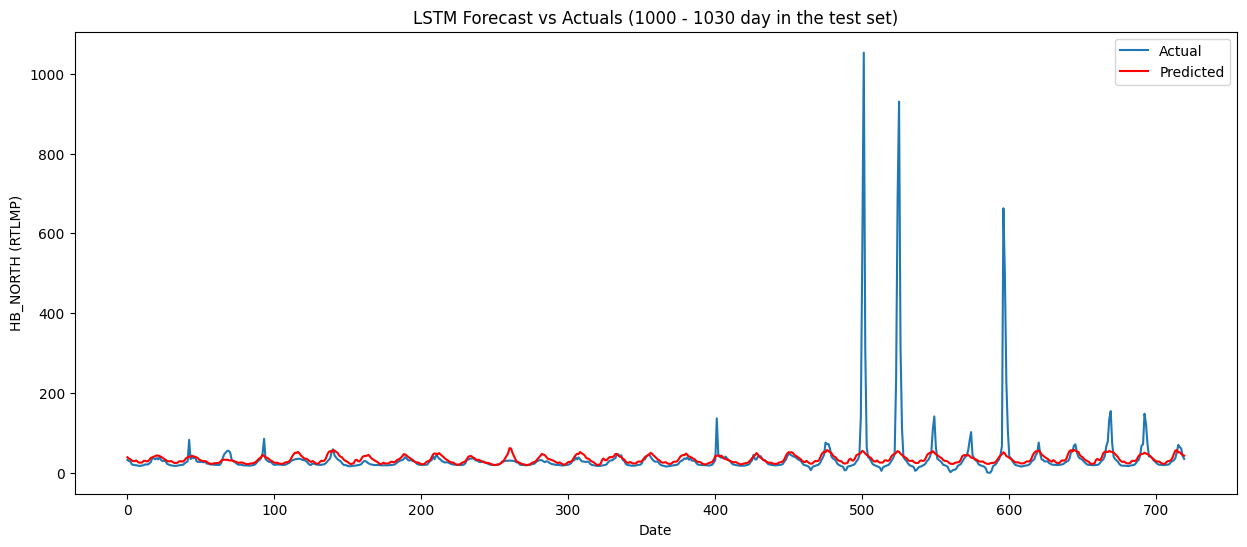

In [36]:
# plot the results for a specific period (e.g., 1000 - 1030 day in the test set)
start_idx = 1000
end_idx = start_idx + 30 * 24  # 1000 - 1030 day in the 

plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[start_idx:end_idx], label='Actual')
plt.plot(y_pred[start_idx:end_idx], label='Predicted', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('HB_NORTH (RTLMP)')
plt.title('LSTM Forecast vs Actuals (1000 - 1030 day in the test set)')
plt.show()

## Random Forest and XGBoost for Comparison

In [37]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt


In [38]:

# load the data
file_path = 'data/Assignment 3 - timeseries_data.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data['MARKETDAY'] = pd.to_datetime(data['MARKETDAY'])

data.set_index('DATETIME', inplace=True)
data['WEEKDAY'] = data['MARKETDAY'].dt.day_name()

# anomaly detection
wepeak_weekday_anomaly = (data['PEAKTYPE'] == 'WEPEAK') & (data['MARKETDAY'].dt.dayofweek < 5)
wepeak_weekdays_anomaly_data = data[wepeak_weekday_anomaly]
offpeak_anomaly = (data['PEAKTYPE'] == 'OFFPEAK') & (data.index.hour >= 7) & (data.index.hour <= 22)
offpeak_anomaly_data = data[offpeak_anomaly]
wdpeak_weekend_anomaly = (data['PEAKTYPE'] == 'WDPEAK') & (data['MARKETDAY'].dt.dayofweek >= 5)
wdpeak_weekend_anomaly_data = data[wdpeak_weekend_anomaly]
onpeak_anomaly = ((data['PEAKTYPE'] == 'WDPEAK') | (data['PEAKTYPE'] == 'WEPEAK')) & (data.index.hour < 7) & (data.index.hour > 22)
onpeak_anomaly_data = data[onpeak_anomaly]

# fix the anomaly
data.loc[wepeak_weekday_anomaly, 'PEAKTYPE'] = 'WDPEAK'


# shift the columns 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)' by one time step
data['ERCOT (WIND_RTI)_lag'] = data['ERCOT (WIND_RTI)'].shift(1)
data['ERCOT (GENERATION_SOLAR_RT)_lag'] = data['ERCOT (GENERATION_SOLAR_RT)'].shift(1)
data['ERCOT (RTLOAD)_lag'] = data['ERCOT (RTLOAD)'].shift(1)

# add rolling statistics
data['WIND_RTI_roll_mean'] = data['ERCOT (WIND_RTI)'].rolling(window=24).mean()
data['GENERATION_SOLAR_RT_roll_mean'] = data['ERCOT (GENERATION_SOLAR_RT)'].rolling(window=24).mean()
data['RTLOAD_roll_mean'] = data['ERCOT (RTLOAD)'].rolling(window=24).mean()
data['WIND_RTI_roll_std'] = data['ERCOT (WIND_RTI)'].rolling(window=24).std()
data['GENERATION_SOLAR_RT_roll_std'] = data['ERCOT (GENERATION_SOLAR_RT)'].rolling(window=24).std()
data['RTLOAD_roll_std'] = data['ERCOT (RTLOAD)'].rolling(window=24).std()

data.dropna(inplace=True)
data.ffill(inplace=True)

# one-hot encodding
data = pd.get_dummies(data, columns=['PEAKTYPE', 'MONTH', 'WEEKDAY', 'YEAR', 'HOURENDING'], drop_first=True)
data = data.drop(['MARKETDAY'], axis=1)


# define features and target variable
features = [col for col in data.columns if col not in ['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']]
X = data[features]
y = data['HB_NORTH (RTLMP)']

# split the data into training, test sets
train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")


X_train shape: (11929, 52)
X_test shape: (2983, 52)


In [39]:
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train_scaled, y_train_scaled)

/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(n_estimators=1000, random_state=42)

MAPE: 0.7341090263106169
RMSE: 75.49593072496815


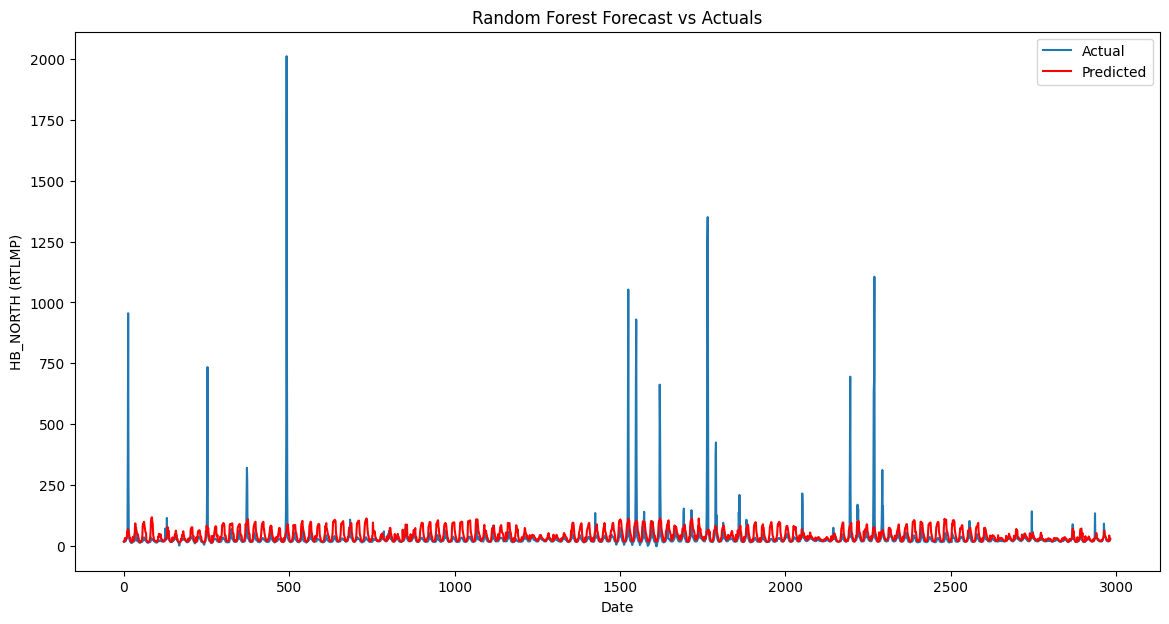

In [44]:
y_pred_rf = rf_model.predict(X_test_scaled)

# inverse transform
y_pred_rf = scaler_y.inverse_transform(y_pred_rf.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# evaluating the model
mape_rf = mean_absolute_percentage_error(y_test_original, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_original, y_pred_rf))

print(f"MAPE: {mape_rf}")
print(f"RMSE: {rmse_rf}")

plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual')
plt.plot(y_pred_rf, label='Predicted', color='red')
plt.title('Random Forest Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('HB_NORTH (RTLMP)')
plt.legend()
plt.show()

In [41]:
#Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train_scaled)

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(n_estimators=1000, random_state=42)

MAPE: 1.532523885307296
RMSE: 81.22856395153721


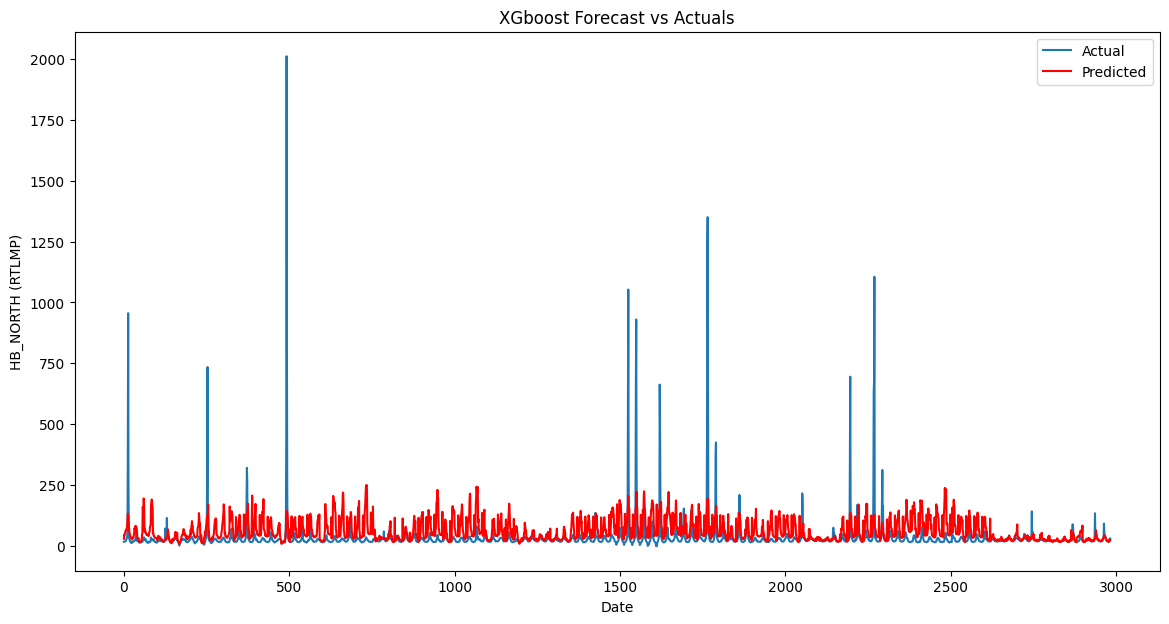

In [45]:
y_pred_gb = gb_model.predict(X_test_scaled)

# inverse transform
y_pred_gb = scaler_y.inverse_transform(y_pred_gb.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# evaluating the model
mape_gb = mean_absolute_percentage_error(y_test_original, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test_original, y_pred_gb))

print(f"MAPE: {mape_gb}")
print(f"RMSE: {rmse_gb}")

plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual')
plt.plot(y_pred_gb, label='Predicted', color='red')
plt.title('XGboost Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('HB_NORTH (RTLMP)')
plt.legend()
plt.show()